In [2]:
#https://www.kaggle.com/tiramysu/how-to-build-recommendation-engine/notebook
!pip install surprise

     |████████████████████████████████| 11.8 MB 4.7 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630210 sha256=bf524622fa4f881ba85b9d4e1feef17b9bf06f6cc72da7d2d5717cf433adb95e
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [3]:
import os

import random

import pandas as pd
import numpy as np
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import missingno

import sklearn
import sklearn.model_selection

from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import KNNWithMeans, SVD
from surprise import accuracy

import pickle

#Settings
pd.set_option('display.max_columns', None)
sns.set(color_codes=True)

#To be avoided in your notebook.
import warnings
warnings.filterwarnings("ignore")

In [4]:
[print(x) for x in os.listdir('/content/drive/MyDrive/AI/RecommendedSystems/Newsportal')];

articles_embeddings.pickle
articles_metadata.csv
clicks_sample.csv


In [5]:
PATH_ARTICLES_DATA = "/content/drive/MyDrive/AI/RecommendedSystems/Newsportal/articles_metadata.csv"
articles_df = pd.read_csv(PATH_ARTICLES_DATA)

In [6]:
articles_df.head(5)

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


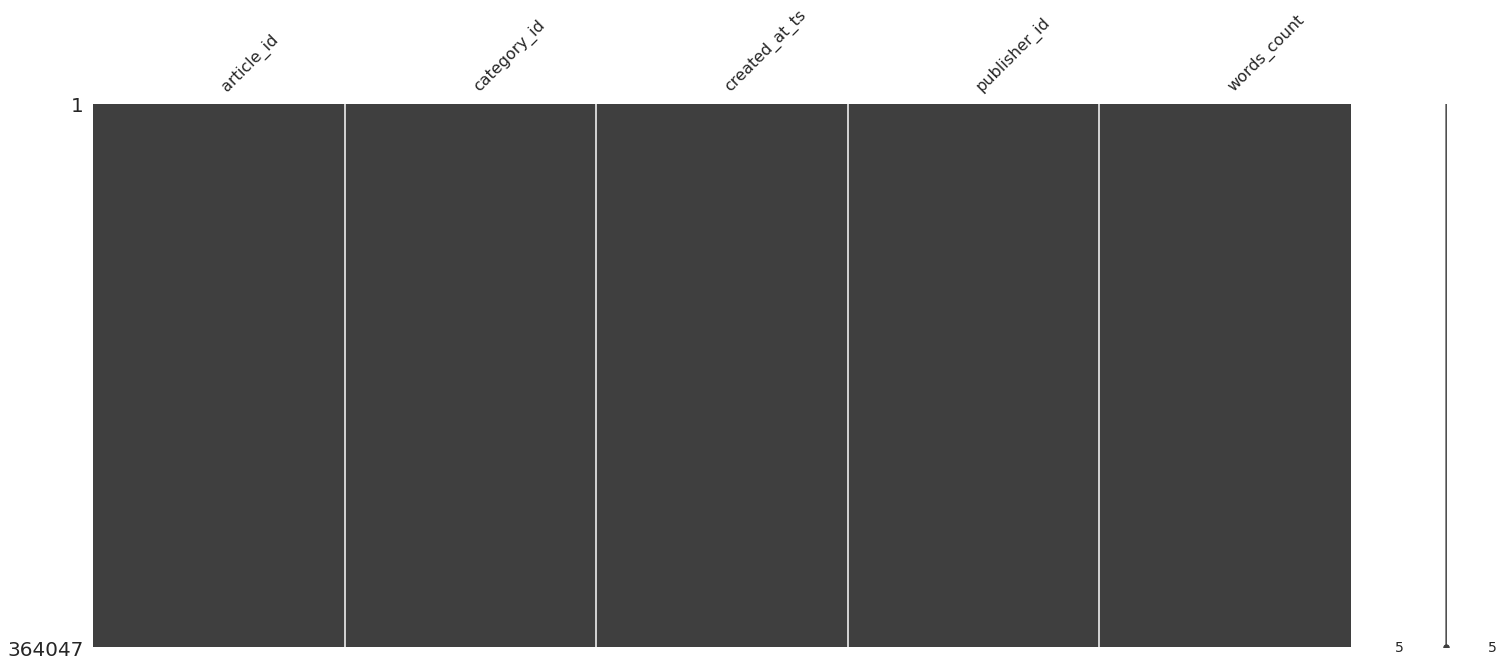

In [7]:
missingno.matrix(articles_df);

In [8]:
articles_df['words_count'].describe()

count    364047.000000
mean        190.897727
std          59.502766
min           0.000000
25%         159.000000
50%         186.000000
75%         218.000000
max        6690.000000
Name: words_count, dtype: float64

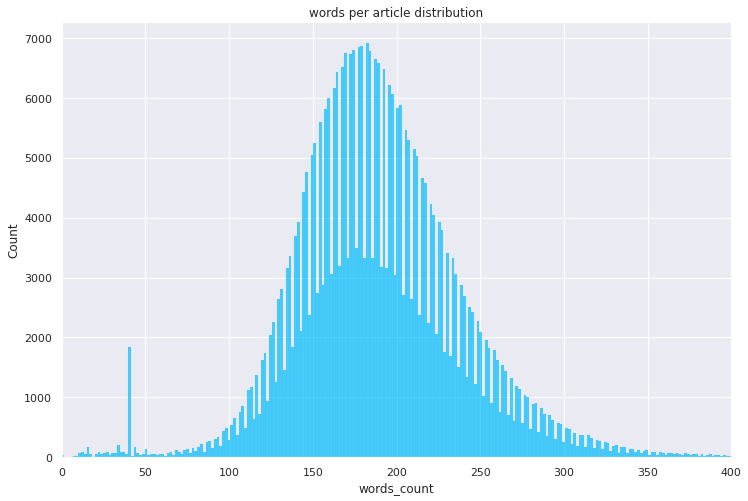

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(articles_df['words_count'],
            color="deepskyblue",
            edgecolor="black",
            alpha=0.7,
            ax=ax)

plt.xlim([0,400])
plt.title('words per article distribution');
plt.show()

In [10]:
print(f'Empty article(s) : {articles_df[articles_df["words_count"] == 0].count()[0]}')

Empty article(s) : 35


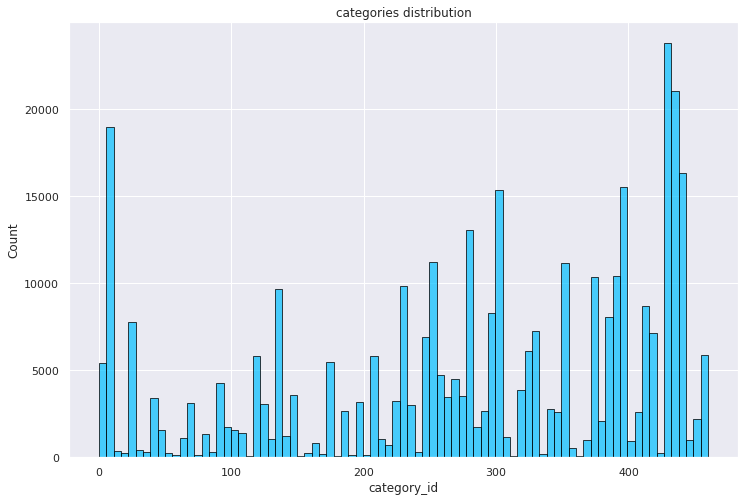

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(articles_df['category_id'],
            color="deepskyblue",
            edgecolor="black",
            alpha=0.7,
            ax=ax)

plt.title('categories distribution');
plt.show()

In [12]:
PATH_CLICK_SAMPLE_DATA = "/content/drive/MyDrive/AI/RecommendedSystems/Newsportal/clicks_sample.csv"
clicks_samp_df = pd.read_csv(PATH_CLICK_SAMPLE_DATA)

In [13]:
clicks_samp_df.head(5)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [14]:
[print(x) for x in clicks_samp_df.columns];

user_id
session_id
session_start
session_size
click_article_id
click_timestamp
click_environment
click_deviceGroup
click_os
click_country
click_region
click_referrer_type


In [16]:
%%time

CLICK_FILES_PATH = "/content/drive/MyDrive/AI/RecommendedSystems/Newsportal/clicks/"

#Get all .csv contain in clicks folder
click_files = [CLICK_FILES_PATH + x for x in os.listdir(CLICK_FILES_PATH)];

#Sort all files PATH contain in list.
click_files.sort()

#Check if all files are present.
print("Total PATH contain in list : ", len(click_files))

list_click_file_to_df = [pd.read_csv(x, index_col=None, header=0) for x in click_files];

#Remove unused columns
list_click_file_to_df_cleaned = [x.drop(columns = ['session_id',
                                                   'session_start',
                                                   'session_size',
                                                   'click_timestamp',
                                                   'click_environment',
                                                   'click_deviceGroup',
                                                   'click_os',
                                                   'click_country',
                                                   'click_region',
                                                   'click_referrer_type']) for x in list_click_file_to_df]

all_clicks_df = pd.concat(list_click_file_to_df_cleaned, axis=0, ignore_index=True)

print(f"DataFrame shape : {all_clicks_df.shape}")

Total PATH contain in list :  359
DataFrame shape : (2808668, 2)
CPU times: user 4.83 s, sys: 803 ms, total: 5.63 s
Wall time: 10.9 s


#Recommendation Models

In [17]:
#Create a map to convert article_id to category
dict_article_categories = articles_df.set_index('article_id')['category_id'].to_dict()

#Get Categorie associate for each article
all_clicks_df['category_id'] = all_clicks_df['click_article_id'].map(dict_article_categories).astype(int)
all_clicks_df['total_click'] = all_clicks_df.groupby(['user_id'])['click_article_id'].transform('count')
all_clicks_df['total_click_by_category_id'] = all_clicks_df.groupby(['user_id','category_id'])['click_article_id'].transform('count')
all_clicks_df['rating'] = all_clicks_df['total_click_by_category_id'] / all_clicks_df['total_click']

print(f'Shape before dropping duplicate : {all_clicks_df.shape}')
all_clicks_df = all_clicks_df.drop(['click_article_id'], axis=1)
all_clicks_df = all_clicks_df.drop_duplicates()
print(f'Shape after dropping duplicate : {all_clicks_df.shape}')

Shape before dropping duplicate : (2808668, 6)
Shape after dropping duplicate : (1782921, 5)


In [18]:
#Remove not used columns
all_clicks_df = all_clicks_df.drop(['total_click', 'total_click_by_category_id'], axis=1)

all_clicks_df[all_clicks_df['user_id'] == 0]

,user_id,category_id,rating
0,0,281,0.250
1,0,136,0.125
1287361,0,209,0.125
1287362,0,431,0.125
1352198,0,375,0.125
1535240,0,186,0.250


In [19]:
#keep ~42 000 users to build our model.
df = all_clicks_df[all_clicks_df['user_id'] < 42000]
print(f'size of our sample : {df.shape}')

size of our sample : (405074, 3)


In [20]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 1))

#Split our Dataframe 75% train / 25% test
data = Dataset.load_from_df(df[['user_id', 'category_id', 'rating']], reader)
train_set, test_set = train_test_split(data, test_size=.25)
print(f'Size of test set : {len(test_set)}')

Size of test set : 101269


#SVD (baseline)

In [21]:
%%time

model = SVD().fit(train_set)

CPU times: user 20.1 s, sys: 19.4 ms, total: 20.1 s
Wall time: 20.2 s


In [22]:
predict = model.test(test_set)

#Print our Results
accuracy.rmse(predict)
accuracy.mse(predict)
accuracy.mae(predict);

print(f'Prediction rating for User 0 with cat 281 : {model.predict(0, 281).est}')
print(f'Current rating : {df[(df["user_id"] == 0) & (df["category_id"] == 281)]["rating"].values}')

RMSE: 0.2033
MSE: 0.0413
MAE:  0.1627
Prediction rating for User 0 with cat 281 : 0.5911534644854303
Current rating : [0.25]


In [23]:
#Function from https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [24]:
top_n = get_top_n(predict, n=10)

In [25]:
#Make simple recommendation for user.
def make_recommendation(user_ID, top_n, df_rating, articles_df):
    """Return a list of recommanded articles based on the taste of the user and all recommended categories
    Args:
        user_id -> user id used for recommendation
        top_n -> top-N recommendation for each user from a set of predictions
        df_rating -> df used to train our algo
        articles_df -> df with metadata of all articles.
    Returns:
        list(recommanded articles), list(recommanded categories)
    """
    #Get top 5 cat and adding it to our list
    recommanded_cat = [iid for iid, _ in top_n[user_ID]]
    
    #If we don't have any recommandation, use our data.
    if not recommanded_cat:
        recommanded_cat = df[df['user_id'] == user_ID].nlargest(1, ['rating'])['category_id'].values
    
    #Select 5 randoms articles for each recommanded cat.
    random_articles_by_cat = [articles_df[articles_df['category_id'] == x]['article_id'].sample(5).values for x in recommanded_cat]
    
    #Select one of the recommanded cat and return 5 articles.
    rand_category = random.sample(random_articles_by_cat, 1)
    
    return rand_category[0], recommanded_cat

In [26]:
recommendation, categories = make_recommendation(1, top_n, df, articles_df)
print(f'recommanded categories for user_id[1] : {categories}')
print(f'recommanded articles for user_id[1] : {recommendation}')

recommanded categories for user_id[1] : [331, 301]
recommanded articles for user_id[1] : [183772 184278 179186 182435 180155]


#KNNWithMeans (Collaborative model)

In [27]:
%%time 

# To use item-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": False,  # Compute similarities between items
}

model = KNNWithMeans(sim_options=sim_options).fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.
CPU times: user 496 ms, sys: 3.47 ms, total: 499 ms
Wall time: 681 ms


In [28]:
predict = model.test(test_set)

#Print our Results
accuracy.rmse(predict)
accuracy.mse(predict)
accuracy.mae(predict);

RMSE: 0.0995
MSE: 0.0099
MAE:  0.0518


In [29]:
print(f'Prediction rating for User 0 with cat 281 : {model.predict(0, 281).est}')
print(f'Current rating : {df[(df["user_id"] == 0) & (df["category_id"] == 281)]["rating"].values}')

Prediction rating for User 0 with cat 281 : 0.2724029697641023
Current rating : [0.25]


In [30]:
top_n = get_top_n(predict, n=10)

In [31]:
recommendation, categories = make_recommendation(3, top_n, df, articles_df)

print(f'recommanded categories for user_id[0] : {categories}')
print(f'recommanded articles for user_id[0] : {recommendation}')

recommanded categories for user_id[0] : [281, 412]
recommanded articles for user_id[0] : [283677 277866 281713 281600 285548]


#Content-Based Prediction

In [32]:
df_cb = df.copy()

#Add number total of rating for each
num_ratings = pd.DataFrame(df_cb.groupby('category_id').count()['rating']).reset_index()
df_cb = pd.merge(left=df_cb, right=num_ratings, on='category_id')
df_cb.rename(columns={'rating_x': 'rating', 'rating_y': 'numRatings'}, inplace=True)

In [33]:
#Category_id
def get_similar_category(category_id, df, n_ratings_filter=50, n_recommendations=5):
    matrix = df.pivot_table(
        index='user_id',
        columns='category_id',
        values='rating'
    )
    
    similar = matrix.corrwith(matrix[category_id])
    corr_similar = pd.DataFrame(similar, columns=['correlation'])
    corr_similar.dropna(inplace=True)
    
    orig = df.copy()
    
    corr_with_category = pd.merge(
        left=corr_similar, 
        right=orig,
        on='category_id')[['category_id', 'correlation', 'numRatings']].drop_duplicates().reset_index(drop=True)
    
    result = corr_with_category[corr_with_category['numRatings'] > n_ratings_filter].sort_values(by='correlation', ascending=False)
    
    result = result[result['category_id'] != category_id]
    return result.head(n_recommendations)

In [34]:
result = get_similar_category(412, df_cb)

#Top 5 corr categories with category_id = 1
result.head(5)

,category_id,correlation,numRatings
38,123,0.854385,5381
108,285,0.820739,996
159,396,0.798165,1209
132,339,0.783105,819
66,184,0.747988,69


In [35]:
train, test = sklearn.model_selection.train_test_split(df_cb, test_size=0.3, random_state=42, shuffle=True)

In [36]:
%%time

all_categories = train['category_id'].unique()
predictions = {}

for val in all_categories:
    predictions[val] = get_similar_category(val, train)

CPU times: user 3min 22s, sys: 6.77 s, total: 3min 29s
Wall time: 3min 38s


In [37]:
train[train['user_id'] == 2]

,user_id,category_id,rating,numRatings
80702,2,26,0.5,7173
70206,2,247,0.5,10496


In [38]:
predictions[332]

,category_id,correlation,numRatings
121,402,1.000000,62
74,271,1.000000,53
80,295,0.991952,72
115,392,0.989992,173
46,176,0.987384,86


In [39]:
test[test['user_id'] == 2]

,user_id,category_id,rating,numRatings


#Select best model and deployment

In [40]:
%%time

# Retrieve the trainset.
train_set = data.build_full_trainset()

# To use item-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": False,  # Compute similarities between items
}

model = KNNWithMeans(sim_options=sim_options).fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.
CPU times: user 1.61 s, sys: 62.9 ms, total: 1.67 s
Wall time: 1.69 s


In [41]:
def predict_best_category_for_user(user_id, model, article_df):
    predictions = {}
    
    #Category 1 to 460
    for i in range(1, 460):
        _, cat_id, _, est, err = model.predict(user_id, i)
        
        #Keep prediction only if we could keep it.
        if (err != True):
            predictions[cat_id] = est
    
    best_cats_to_recommend = dict(sorted(predictions.items(), key=lambda x: x[1], reverse=True)[:5])
    
    recommended_articles = []
    for key, _ in best_cats_to_recommend.items():
        recommended_articles.append(int(articles_df[articles_df['category_id'] == key]['article_id'].sample(1).values))
    
    #return random_articles_for_best_cat, best_cat_to_recommend
    return recommended_articles, best_cats_to_recommend

In [42]:
results, recommended_cats = predict_best_category_for_user(1, model, articles_df)

print(f'Reco cat : {recommended_cats}')
print(f'5 randoms articles from cat {results}')

Reco cat : {22: 0.5, 70: 0.5, 159: 0.5, 370: 0.5, 62: 0.31537715348959416}
5 randoms articles from cat [24999, 43052, 78546, 227595, 38905]


In [43]:
# Save to file in the current working directory
pkl_filename = "pickle_surprise_model_KNNWithMeans.pkl"

with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [44]:
results, recommended_cats = predict_best_category_for_user(1, pickle_model, articles_df)

print(f'Reco cat : {recommended_cats}')
print(f'5 randoms articles from cat {results}')

Reco cat : {22: 0.5, 70: 0.5, 159: 0.5, 370: 0.5, 62: 0.31537715348959416}
5 randoms articles from cat [25001, 43058, 78546, 227595, 38875]
